In [129]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from operator import itemgetter

from PIL import Image
import tensorflow as tf


In [2]:
def predict_image(image, model):
    category_to_label = {
        0: "Negative",
        1: "Primordial", 
        2: "Primary", 
        3: "Secondary", 
        4: "Tertiary", 
    }

    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    predicted_category, proba = np.argmax(pred),  np.max(pred)
    predicted_label = category_to_label[predicted_category]
    return predicted_label, proba


In [3]:
def display_slice_and_predictions(coupe, predicted_locations):
    linewidth=3
    label_to_color = {
        "Negative": "grey", 
        "Primordial": "blue", 
        "Primary": "red", 
        "Secondary": "green", 
        "Tertiary": "darkgreen"
    }
    
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(coupe)
    ax = plt.gca()
    for prediction in predicted_locations:
        box = prediction["bbox"]
        label = prediction["label"]
        proba = prediction["proba"]

        color = label_to_color[label]
        text = "{}: {:.2f}".format(label, proba)
        linestyle = "-" if proba == 1 else "--"

        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth, linestyle=linestyle
        )
        ax.add_patch(patch)

        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 1},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()

In [4]:
def generate_random_windows_for_image(image, window_size=1000, num_windows=1000):
    """generator of square boxes that create a list of random
    windows for the given image"""
    mean = window_size
    std = 0.15 * window_size
    
    c = 0
    while True:
        width = np.random.normal(mean, std)
        x1 = np.random.randint(0, image.width)
        y1 = np.random.randint(0, image.height)

        bbox = (x1, y1, x1 + width, y1 + width)
        yield bbox
        c += 1
        
        if c > num_windows:
            break

In [5]:

def predict_locations_for_windows(coupe, window_size, model, num_windows=1000):
    boxes = generate_random_windows_for_image(coupe, window_size=window_size, num_windows=num_windows)
    predicted_locations = []
    for box in boxes:
        cropped_image = coupe.crop(box)
        label, proba = predict_image(cropped_image, model)
        predicted_locations.append({
                "bbox": box,
                "label": label,
                "proba": proba
            })
    return predicted_locations

def filter_predictions(predicted_locations, proba_threshold=0.8):
    def should_keep_prediction(label, proba):
        if label == "Negative":
            return False
        if proba < proba_threshold:
            return False
        return True

    selected_locations = [
        prediction
        for prediction in predicted_locations
        if should_keep_prediction(prediction["label"], prediction["proba"])
    ]

    return selected_locations


In [6]:
def load_true_locations(path, image_filename):
    """Return list of {bbox, label, proba}."""
    df = pd.read_csv(path)
    df = df.loc[df["filename"] == image_filename] 
    locations = []
    for _, row in df.iterrows():
        loc_dict = {
            "bbox": (row['xmin'], row['ymin'], row['xmax'], row['ymax']),
            "label": row["class"],
            "proba": 1
        }
        locations.append(loc_dict)
    return locations

In [7]:
this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data")
MODELS_FOLDER = os.path.join(this_folder, "models")

IMAGE_TO_ANALYSE = 'D-1M01-4.jpg'
MODEL_NAME_FOR_PREDICTION = "classifier2"


coupe = Image.open(os.path.join(DATA_FOLDER, "coupes_jpg", IMAGE_TO_ANALYSE))
true_locations = load_true_locations(os.path.join(DATA_FOLDER, "scenario1", 'labels.csv'), IMAGE_TO_ANALYSE)
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, MODEL_NAME_FOR_PREDICTION))


2021-10-27 11:27:35.327296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-27 11:27:35.327317: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-27 11:27:35.327332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frcaud-Latitude-7420): /proc/driver/nvidia/version does not exist
2021-10-27 11:27:35.327503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## True locations

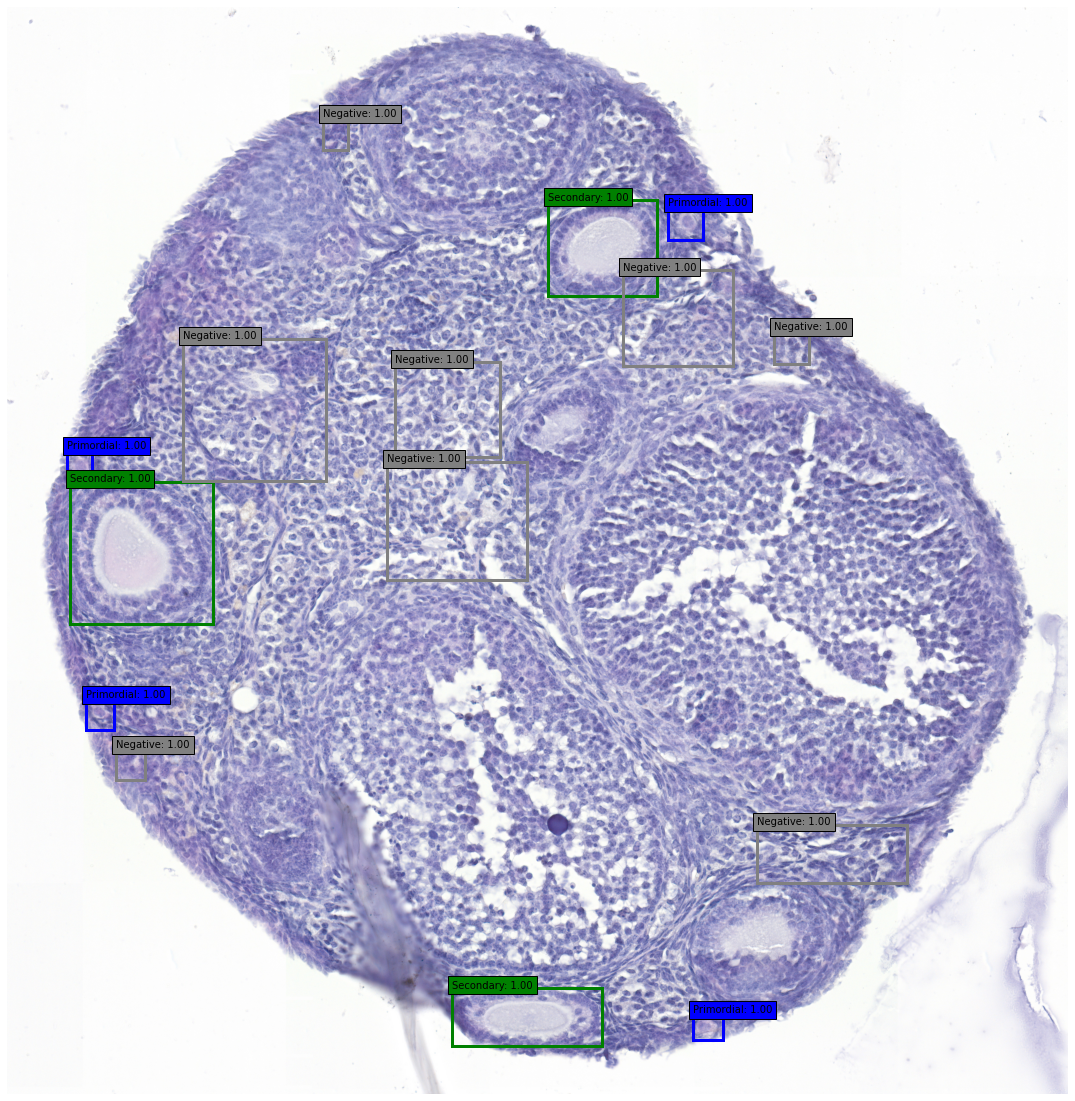

In [8]:
display_slice_and_predictions(coupe, true_locations)

## Predicted locations

In [18]:
predicted_locations = predict_locations_for_windows(coupe, window_size=1000, model=model_loaded, num_windows=10000)

In [20]:
len(predicted_locations)

10001

27


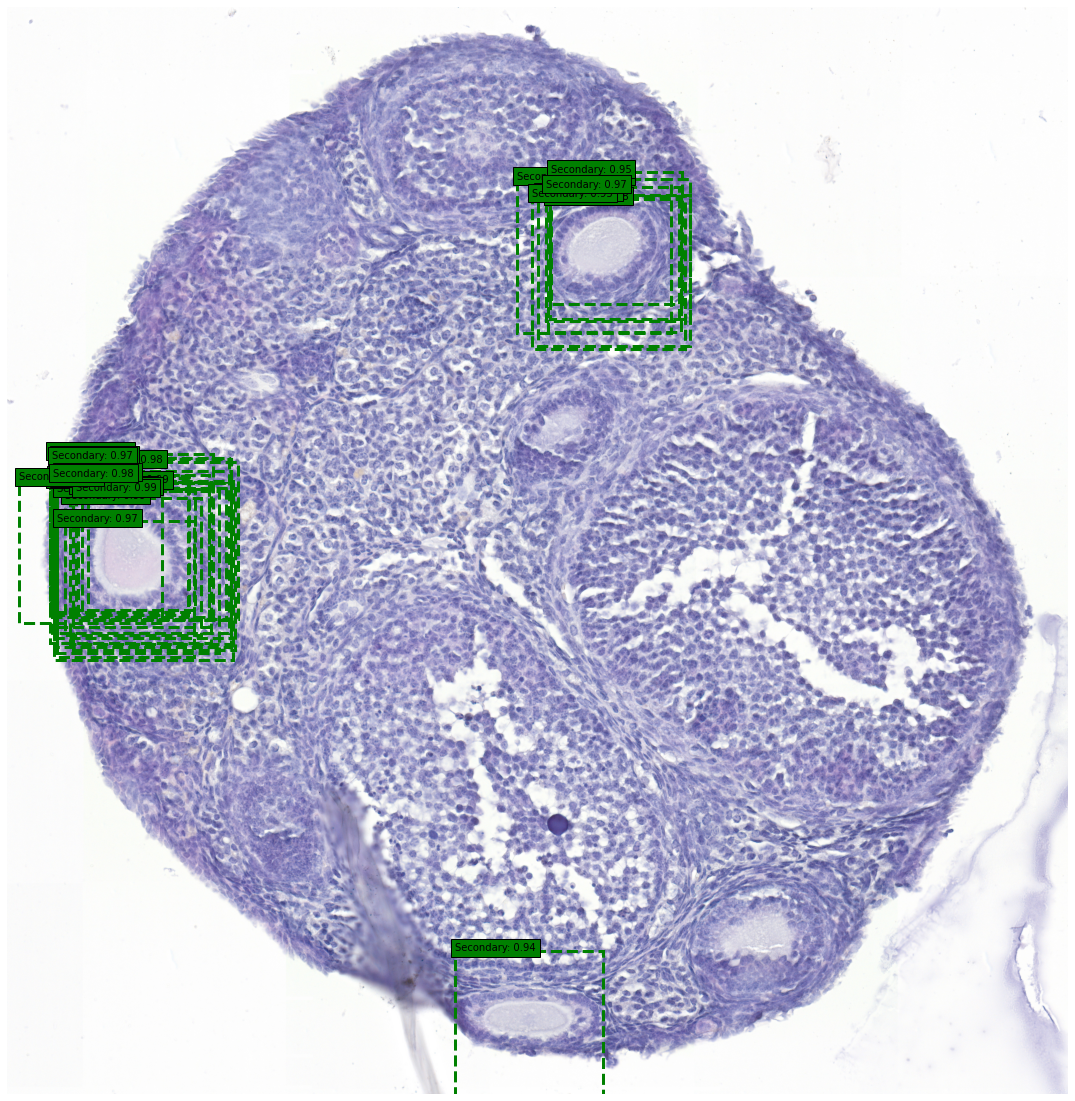

In [29]:
selected_locations = filter_predictions(predicted_locations, proba_threshold=0.935)
print(len(selected_locations))
display_slice_and_predictions(coupe, selected_locations)

## IOU-NMS to remove duplicates

In [130]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, x2, y2]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, xmax, ymax]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    lu = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    rd = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    intersection = np.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1[:,2] - boxes1[:, 0]) * (boxes1[:,3] - boxes1[:, 1])
    boxes2_area = (boxes2[:,2] - boxes2[:, 0]) * (boxes2[:,3] - boxes2[:, 1])
    union_area = np.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return np.clip(intersection_area / union_area, 0.0, 1.0)



In [131]:
def NMS(selected_locations, iou_threshold=0.4):
    selected_locations_NMS = []
    selected_locations_sorted = list(sorted(selected_locations, key=itemgetter('proba'), reverse=True))
    # boxes_sorted = np.array([location['bbox'] for location in selected_locations_sorted])
    while len(selected_locations_sorted) !=0:
        best_box = selected_locations_sorted.pop(0)
        selected_locations_NMS.append(best_box)
        best_box_coords = np.array(best_box["bbox"]).reshape(1,-1)
        other_boxes_coords = np.array([location['bbox'] for location in selected_locations_sorted]).reshape(-1,4)
        ious = compute_iou(best_box_coords, other_boxes_coords)
        for i, iou in reversed(list(enumerate(ious[0]))):           
            if iou > iou_threshold:
                selected_locations_sorted.pop(i)
    return selected_locations_NMS

In [132]:
selected_locations_NMS = NMS(selected_locations, iou_threshold=0.4)
selected_locations_NMS

[{'bbox': (441, 3017, 1260.0052951731986, 3836.0052951731986),
  'label': 'Secondary',
  'proba': 0.9933815},
 {'bbox': (3386, 1203, 4215.307645176572, 2032.3076451765714),
  'label': 'Secondary',
  'proba': 0.97648424},
 {'bbox': (2801, 5905, 3727.868223981416, 6831.868223981416),
  'label': 'Secondary',
  'proba': 0.93719393}]

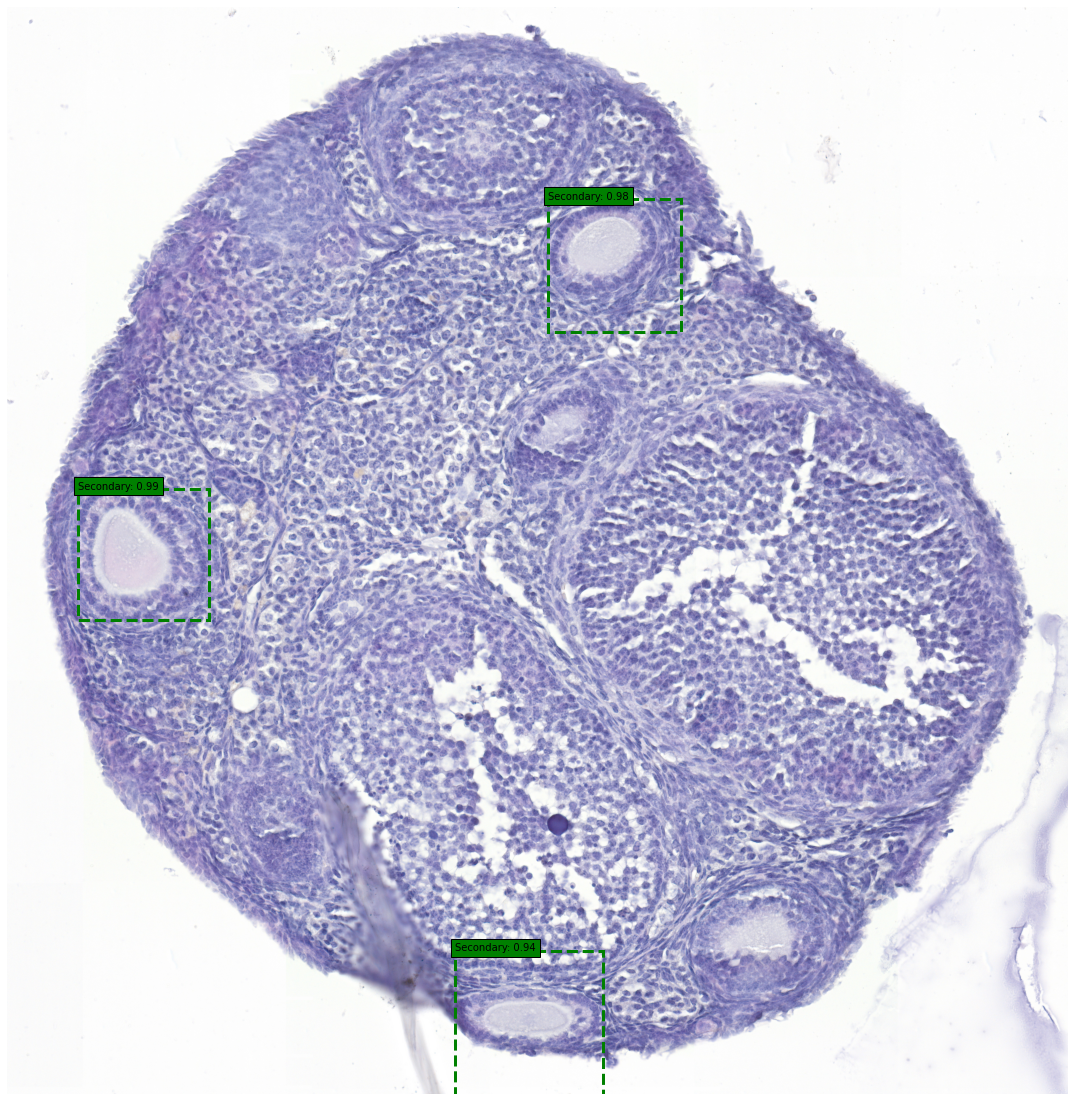

In [133]:
display_slice_and_predictions(coupe, selected_locations_NMS)